In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, tqdm_notebook, trange
pd.pandas.set_option('display.max_columns', None)

import Validation

C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('Prob_2_train.csv')
test = pd.read_excel('Test_dataset.xlsx', sheet_name = 'Test_dataset')
train.shape, test.shape

((10714, 28), (14498, 27))

In [3]:
cat_feats = [feat for feat in train.columns if train[feat].dtypes == 'O']
num_feats = [feat for feat in train.columns if train[feat].dtypes != 'O' and feat not in ['people_ID', 'Infect_Prob']]
len(cat_feats), len(num_feats)

(10, 16)

In [4]:
data = pd.concat([train, test]).reset_index(drop=True)
data.shape

(25212, 28)

In [5]:
data[cat_feats].isnull().sum()

Region                      0
Gender                      0
Designation                 0
Name                       52
Married                     0
Occupation                747
Mode_transport              3
comorbidity               226
Pulmonary score             0
cardiological pressure     97
dtype: int64

In [6]:
data['Name'] = data['Name'].fillna('Not_Given')
data['Mode_transport'] = data['Mode_transport'].fillna('Car')
data['comorbidity'] = data['comorbidity'].fillna("None")
data['cardiological pressure'] = data['cardiological pressure'].fillna('Normal')

data['Occupation_na'] = np.where(data['Occupation'].isnull(), 1, 0)
data['Occupation'] = data['Occupation'].fillna("Other")

data['Region'] = pd.factorize(data['Region'])[0]
data['Name'] = pd.factorize(data['Name'])[0]
data['Gender'] = pd.factorize(data['Gender'])[0]
data['Married'] = pd.factorize(data['Married'])[0]
data['Occupation'] = pd.factorize(data['Occupation'])[0]
data['Mode_transport'] = pd.factorize(data['Mode_transport'])[0]
data['comorbidity'] = pd.factorize(data['comorbidity'])[0]
data['Pulmonary score'] = pd.factorize(data['Pulmonary score'])[0]
data['cardiological pressure'] = pd.factorize(data['cardiological pressure'])[0]

In [7]:
data.drop(['Designation'], axis=1, inplace=True)

In [8]:
data[num_feats].isnull().sum()

Children            311
cases/1M              0
Deaths/1M             0
Age                   0
Coma score            0
Diuresis              0
Platelets           924
HBB                  16
d-dimer            1114
Heart rate         1114
HDL cholesterol      35
Charlson Index        0
Blood Glucose         0
Insurance          1090
salary                0
FT/month            723
dtype: int64

In [9]:
data['Children_na'] = np.where(data['Children'].isnull(), 1, 0)
data['Children'] = data['Children'].fillna(0)
data['Diuresis_na'] = np.where(data['Diuresis'].isnull(), 1, 0)
data['Diuresis'] = data['Diuresis'].fillna(data['Diuresis'].mean())
data['Platelets_na'] = np.where(data['Platelets'].isnull(), 1, 0)
data['Platelets'] = data['Platelets'].fillna(data['Platelets'].mean())
data['HBB'] = data['HBB'].fillna(data['HBB'].mean())
data['d-dimer_na'] = np.where(data['d-dimer'].isnull(), 1, 0)
data['d-dimer'] = data['d-dimer'].fillna(data['d-dimer'].mean())
data['Heart_rate_na'] = np.where(data['Heart rate'].isnull(), 1, 0)
data['Heart rate'] = data['Heart rate'].fillna(data['Heart rate'].mean())
data['HDL cholesterol'] = data['HDL cholesterol'].fillna(data['HDL cholesterol'].mean())
data['Insurance_na'] = np.where(data['Insurance'].isnull(), 1, 0)
data['Insurance'] = data['Insurance'].fillna(data['Insurance'].mean())
data['FT_na'] = np.where(data['FT/month'].isnull(), 1, 0)
data['FT/month'] = data['FT/month'].fillna(0)

In [10]:
data['Age_bins'] = 1
data.loc[((data['Age']>25)&(data['Age']<=35)), 'Age_bins'] = 2
data.loc[((data['Age']>35)&(data['Age']<=45)), 'Age_bins'] = 3
data.loc[((data['Age']>45)&(data['Age']<=55)), 'Age_bins'] = 4
data.loc[((data['Age']>55)&(data['Age']<=70)), 'Age_bins'] = 5
data['Age_bins'].value_counts()

5    6281
4    4778
2    4765
1    4750
3    4638
Name: Age_bins, dtype: int64

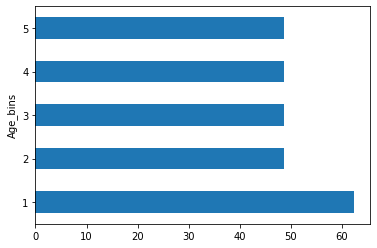

In [11]:
data.groupby(['Age_bins'])['Infect_Prob'].median().plot(kind='barh')

In [12]:
cat = ['Region', 'Name', 'Occupation', 'Mode_transport', 'comorbidity', 'Pulmonary score', 'cardiological pressure', 'Age_bins']
binary = ['Gender', 'Married', 'Occupation_na', 'Children_na', 'Diuresis_na', 'Platelets_na', 'd-dimer_na', 'Heart_rate_na', 'Insurance_na',
'FT_na']
cont = num_feats

In [13]:
len(cat), len(binary), len(cont)

(8, 10, 16)

In [14]:
data.shape

(25212, 36)

In [15]:
del data['people_ID']
del data['Infect_Prob']
data.shape

(25212, 34)

In [16]:
data.isnull().sum().sum()

0

In [17]:
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [18]:
data_knn = copy.deepcopy(data)
for feat in tqdm_notebook(cont):
    X_knn = data_knn.drop(feat, axis=1)
    y_knn = data_knn[feat]
    for k in tqdm_notebook([5, 10, 50, 200, 1000]):
        knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
        knn.fit(X_knn, y_knn)
        pred_knn = knn.predict(X_knn)
        data['dist_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = y_knn-pred_knn
        data[feat+'_divided_by_'+str(k)+'_nearest_neighbors'] = y_knn/pred_knn
        data[feat+'_'+str(k)+'_nearest_neighbors'] = pred_knn

In [19]:
for feat in tqdm_notebook(cat):
    X_knn = data_knn.drop(feat, axis=1)
    y_knn = data_knn[feat].factorize()[0]
    for k in tqdm_notebook([5, 10, 50, 200, 1000]):
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_knn, y_knn)
        pred_knn = knn.predict(X_knn)
        pr = knn.predict_proba(X_knn)
        prob_of_curr_class = np.array([pr[n, j] for n , j in enumerate(y_knn)])
        data['Is_same_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = (y_knn == pred_knn)
        data['most_likelihood_class_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = pred_knn
        data['prob_of_most_likelihood_class_'+feat+'_from_'+str(k)+'_nearest_neighbors'] = pr.max(axis=1)
        data['prob_of_'+feat+'_'+str(k)+'_nearest_neighbors'] = prob_of_curr_class
        data['dist_to_most_likelihood_class_'+feat+'_'+str(k)+'_nearest_neighbors'] = pr.max(axis=1) -\
        prob_of_curr_class
        try:
            data['dist_from_least_likelihood_nonzero_class_'+feat+'_'+str(k)+'_nearest_neighbors'] = prob_of_curr_class -\
            np.array([i[i>0].min() for i in pr])
        except:
            pass

In [20]:
data_knn_feat = data[data.columns[34:]]

In [21]:
data_knn_feat.to_csv('prob_2_data_knn_feat.csv', index=False)

In [22]:
data.shape

(25212, 514)

In [23]:
for bin_i in tqdm_notebook(binary):
    for cat_name in cat:
        if cat_name != bin_i:
            data[cat_name+'_intersect_'+bin_i] = data[cat_name]*data[bin_i]
for_dr = []            
for bin_i in tqdm_notebook(binary):
    for_dr.append(bin_i)
    for bin_j in list(set(binary) - set(for_dr)):
        for cat_name in cat:
            if bin_i != bin_j:
                if cat_name != bin_i:
                    data[cat_name+'_intersect_'+bin_i+'_'+bin_j] = data[cat_name]*data[bin_i]*data[bin_j]

In [24]:
data.shape

(25212, 954)

In [25]:
data.to_csv('prob_2_Final_knn_data_fe.csv', index=False)
data.shape

(25212, 954)

In [26]:
cat2 = cat + list(data.columns[514:])

In [27]:
def coma(data):
    dataset = data.copy()
    score = []
    for i in range(dataset.shape[0]):
        if dataset['Coma score'][i]<=8:
            score.append(1) #Severe
        elif (dataset['Coma score'][i]>=9)and(dataset['Coma score'][i]<=12):
            score.append(2) #Moderate
        else:
            score.append(3) #Mild
    return score

data['coma_score_bins'] = coma(data)

In [28]:
data['coma_score_bins'].value_counts()

1    11629
2     7782
3     5801
Name: coma_score_bins, dtype: int64

In [29]:
# data.groupby(['coma_score_bins'])['Infect_Prob'].mean().plot(kind='barh')

In [30]:
data['no_fatality_cases'] = data['cases/1M']-data['Deaths/1M']
data['no_fatality_cases'].describe()

count    25212.000000
mean         3.787006
std          3.206201
min          0.000000
25%          2.000000
50%          2.000000
75%          6.000000
max         10.000000
Name: no_fatality_cases, dtype: float64

In [31]:
age_grp = data.groupby(['Age']).agg({
    'Coma score': ['mean'],
    'Diuresis': ['mean'],
    'Platelets': ['mean'],
    'HBB': ['mean'],
    'd-dimer': ['mean'],
    'Heart rate': ['mean'],
    'HDL cholesterol': ['mean'],
    'Charlson Index': ['mean']
})
age_grp.columns = ['_Age_grp_'.join(col) for col in age_grp.columns]
age_grp = age_grp.reset_index(drop=False)
age_grp.head()

Age  Coma score_Age_grp_mean  Diuresis_Age_grp_mean  \
0   16                 9.209350             657.965761   
1   17                 8.882883             658.401566   
2   18                 8.833333             660.088715   
3   19                 9.000000             658.137985   
4   20                 9.245495             658.876860   

   Platelets_Age_grp_mean  HBB_Age_grp_mean  d-dimer_Age_grp_mean  \
0               85.022358        112.217480            272.264228   
1               86.844595        116.186937            277.630631   
2               90.399573        113.933761            270.608974   
3               89.157464        114.963190            276.607362   
4               88.371622        107.270270            277.835586   

   Heart rate_Age_grp_mean  HDL cholesterol_Age_grp_mean  \
0                73.453252                     52.642276   
1                75.882883                     52.412162   
2                75.113248                     53.190171   
3                74.883436                     52.617587   
4                75.653153                     52.123874   

   Charlson Index_Age_grp_mean  
0                    19.890244  
1                    20.684685  
2                    19.959402  
3                    19.071575  
4                    19.006757

In [32]:
data['insurance_to_salary'] = data['Insurance']/data['salary']
data['diuresis_to_coma_score'] = data['Diuresis']/data['Coma score']
data['platelets_to_coma_score'] = data['Platelets']/data['Coma score']
data['hbb_to_coma_score'] = data['HBB']/data['Coma score']
data['HDL_to_coma_score'] = data['HDL cholesterol']/data['Coma score']
data['charlson_to_coma_score'] = data['Charlson Index']/data['Coma score']

In [33]:
data['diuresis_mult_coma_score'] = data['Diuresis']*data['Coma score']
data['platelets_mult_coma_score'] = data['Platelets']*data['Coma score']
data['hbb_mult_coma_score'] = data['HBB']*data['Coma score']
data['HDL_mult_coma_score'] = data['HDL cholesterol']*data['Coma score']
data['charlson_mult_coma_score'] = data['Charlson Index']*data['Coma score']

In [34]:
data['platelets_to_diuresis'] = data['Platelets']/data['Diuresis']
data['hbb_to_diuresis'] = data['HBB']/data['Diuresis']
data['dimer_to_diuresis'] = data['d-dimer']/data['Diuresis']
data['heart_to_diuresis'] = data['Heart rate']/data['Diuresis']
data['hdl_to_diuresis'] = data['HDL cholesterol']/data['Diuresis']
data['charlson_to_diuresis'] = data['Charlson Index']/data['Diuresis']

data['platelets_mult_diuresis'] = data['Platelets']*data['Diuresis']
data['hbb_mult_diuresis'] = data['HBB']*data['Diuresis']
data['dimer_mult_diuresis'] = data['d-dimer']*data['Diuresis']
data['heart_mult_diuresis'] = data['Heart rate']*data['Diuresis']
data['hdl_mult_diuresis'] = data['HDL cholesterol']*data['Diuresis']
data['charlson_mult_diuresis'] = data['Charlson Index']*data['Diuresis']

In [35]:
data['hbb_to_Platelets'] = data['HBB']/data['Platelets']
data['dimer_to_Platelets'] = data['d-dimer']/data['Platelets']
data['heart_to_Platelets'] = data['Heart rate']/data['Platelets']
data['hdl_to_Platelets'] = data['HDL cholesterol']/data['Platelets']
data['charlson_to_Platelets'] = data['Charlson Index']/data['Platelets']

data['hbb_mult_Platelets'] = data['HBB']*data['Platelets']
data['dimer_mult_Platelets'] = data['d-dimer']*data['Platelets']
data['heart_mult_Platelets'] = data['Heart rate']*data['Platelets']
data['hdl_mult_Platelets'] = data['HDL cholesterol']*data['Platelets']
data['charlson_mult_Platelets'] = data['Charlson Index']*data['Platelets']

In [36]:
data['dimer_to_HBB'] = data['d-dimer']/data['HBB']
data['heart_to_HBB'] = data['Heart rate']/data['HBB']
data['hdl_to_HBB'] = data['HDL cholesterol']/data['HBB']
data['charlson_to_HBB'] = data['Charlson Index']/data['HBB']

data['dimer_mult_HBB'] = data['d-dimer']*data['HBB']
data['heart_mult_HBB'] = data['Heart rate']*data['HBB']
data['hdl_mult_HBB'] = data['HDL cholesterol']*data['HBB']
data['charlson_mult_HBB'] = data['Charlson Index']*data['HBB']

In [37]:
data['heart_to_d-dimer'] = data['Heart rate']/data['d-dimer']
data['hdl_to_d-dimer'] = data['HDL cholesterol']/data['d-dimer']
data['charlson_to_d-dimer'] = data['Charlson Index']/data['d-dimer']

data['heart_mult_d-dimer'] = data['Heart rate']*data['d-dimer']
data['hdl_mult_d-dimer'] = data['HDL cholesterol']*data['d-dimer']
data['charlson_mult_d-dimer'] = data['Charlson Index']*data['d-dimer']

In [38]:
data['hdl_to_Heart rate'] = data['HDL cholesterol']/data['Heart rate']
data['charlson_to_Heart rate'] = data['Charlson Index']/data['Heart rate']

data['hdl_mult_Heart rate'] = data['HDL cholesterol']*data['Heart rate']
data['charlson_mult_Heart rate'] = data['Charlson Index']*data['Heart rate']

In [39]:
data['charlson_to_HDL cholesterol'] = data['Charlson Index']/data['HDL cholesterol']

data['charlson_mult_HDL cholesterol'] = data['Charlson Index']*data['HDL cholesterol']

In [40]:
data.shape

(25212, 1009)

In [41]:
data = data.merge(age_grp, on='Age', how='left')
data.shape

(25212, 1017)

In [42]:
data.to_csv('prob_2_Final_FE_data.csv', index=False)